In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import pandas as pd
from simulate import sim
import matplotlib.pyplot as plt

(CVXPY) Sep 19 05:04:02 PM: Encountered unexpected exception importing solver SCS:
ImportError('libmkl_rt.so.2: cannot open shared object file: No such file or directory')


First, read in problem parameters. These can come from any source, but they should be reshaped into `np.array` objects with dimensions specified in the docstring of `sim`.

In [2]:
# System base in MVA, taken from PowerWorld. Used to convert from MW to per-unit.
base = 100

# Key/value pairs are the names and contents of the sheets in the excel model data
model = pd.read_excel('Example11_9_Network_Model_Jul19.xlsx', sheet_name=None)

# The initial conditions of the demand curves
load = model['LoadProfiles'].set_index('Date')
load.index+=pd.TimedeltaIndex(load.HE-1, unit='h')
load = load.drop(columns='HE')
demand = np.array(load.loc[:,load.columns.str.contains('Load')]).T/base
price = np.array(load.loc[:,load.columns.str.contains('Price')]).T

# Generation profiles for intermittant sources
gen = pd.read_excel('Normalized generation profiles.xlsx', sheet_name='Normalized', index_col=0)
gen.index+=pd.TimedeltaIndex(gen.HE-1, unit='h')
gen = gen.drop(columns='HE')
gen = gen.loc[load.index, model['Gen']['Type']]
gen = np.array(gen*np.array(model['Gen']['Installed MW'])).T/base

# Process Ybus matrix
Y = model['YBus']
Y = Y.drop(columns=['Number', 'Name'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = model['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# The buses with generators and loads
L = np.array(model['Load']['Number of Bus']-1)
G = np.array(model['Gen']['Number of Bus']-1)

# Number of timesteps to fully charge/discharge storage
b_duration = 4

# Elasticity
epsilon = -0.5*np.ones((len(L), gen.shape[1]))

To run a simulation, call `sim` as follows. Be careful with units!

In [3]:
opf = sim(
    L=L,
    G=G,
    B=B,
    p_g_int_max=gen,
    p_g_dis_min=np.array([0,0,0])/base, # To avoid nonconvex unit commitment problem
    p_g_dis_max=np.array(model['Gen']['Installed MW'])/base,
    epsilon = epsilon,
    price=price,
    demand=demand,
    b_total=2000/base,
    b_duration=4,
    p_line_max=P_line,
    cost_lin=np.array([10,8,12]), # From PowerWorld
    cost_quad=np.array([.016,0.18,0.18]), # From PowerWorld
    generator_ratio=.5
)

Always retrieve the results as a dictionary, as the order of variables in `opf.variables()` may change from run to run.

In [4]:
results={var.name(): var.value for var in opf.variables()}

A demonstration of how to visualize the results. Other variables can also be retrieved, such as transmission constraints and voltage angles.

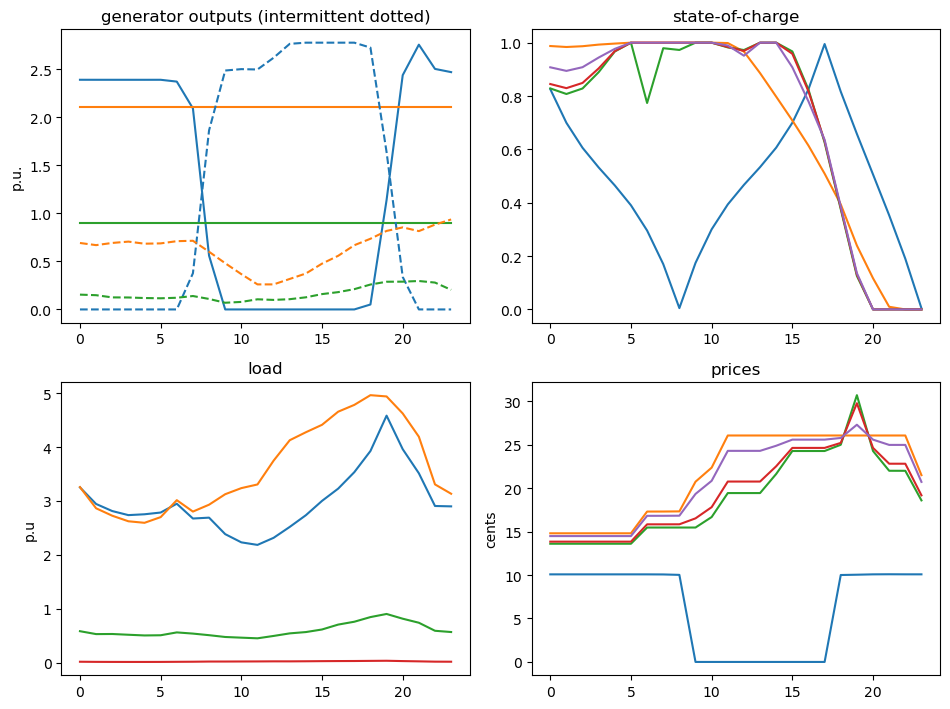

In [5]:
fig, ax = plt.subplots(2,2)

# Generators
ax[0,0].plot(results['p_g_dis'].T)
ax[0,0].plot(results['p_g_int'].T,'--')
[ax[0,0].lines[i].set_color(ax[0,0].lines[i-3].get_color()) for i in range(3,6)]
ax[0,0].set_ylabel('p.u.')
ax[0,0].set_title('generator outputs (intermittent dotted)')

# Storage
ax[0,1].plot((results['b_0']+np.cumsum(results['p_b'],axis=1).T)/results['b'])
ax[0,1].set_title('state-of-charge')

# Loads
ax[1,0].plot(results['p_d'].T)
ax[1,0].set_ylabel('p.u')
ax[1,0].set_title('load')

# The prices are the negative of the dual of the first constraint
ax[1,1].plot(-opf.constraints[0].dual_value.T)
ax[1,1].set_ylabel('cents')
ax[1,1].set_title('prices')

fig.set_size_inches(fig.get_size_inches()*1.5)
fig.tight_layout()
fig.show()